In [1]:
!pip install numpy opencv-python pywavelets scikit-image

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 67.3 MB/s eta 0:00:00


In [2]:
import cv2
import numpy as np
import pywt
from skimage.metrics import peak_signal_noise_ratio as psnr, structural_similarity as ssim
import matplotlib.pyplot as plt
from scipy.fftpack import dct, idct
import time

In [3]:
img = cv2.imread("/content/unnamed.jpg")
imgrgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.uint8)
imggrey = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY).astype(np.uint8)

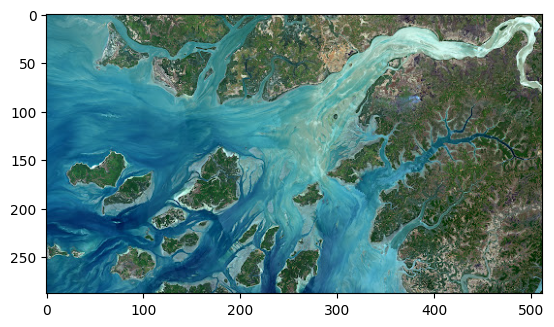

In [4]:
plt.imshow(imgrgb)

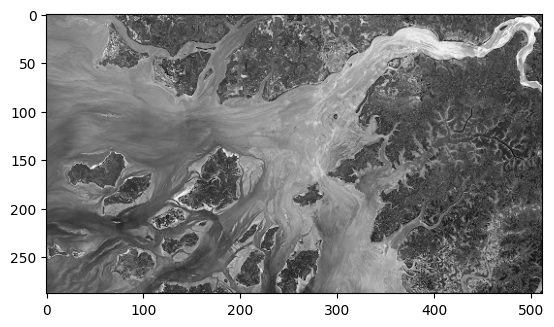

In [5]:
plt.imshow(imggrey, cmap='gray')

In [6]:
imggrey.shape

(288, 512)

In [7]:
cv2.imwrite("image_to_compress.jpg", imggrey)

True

In [8]:
def block_process(image, block_size=8):
    h, w = image.shape
    h_pad = (block_size - h % block_size) % block_size
    w_pad = (block_size - w % block_size) % block_size
    image = np.pad(image, ((0, h_pad), (0, w_pad)), mode='constant')
    blocks = image.reshape(image.shape[0] // block_size, block_size,
                           image.shape[1] // block_size, block_size).swapaxes(1, 2)
    return blocks, image.shape

def unblock_process(blocks, shape, block_size=8):
    image = blocks.swapaxes(1, 2).reshape(shape)
    return image


In [9]:
def quantize(block, q_factor=10):
    return np.round(block / q_factor)

def dequantize(block, q_factor=10):
    return block * q_factor

In [10]:
def estimate_compression_ratio(original, quantized_blocks):
    original_bits = original.size * 8  # 8 bits per pixel
    flat = quantized_blocks.flatten()
    unique, counts = np.unique(flat, return_counts=True)
    probs = counts / counts.sum()
    entropy = -np.sum(probs * np.log2(probs))
    compressed_bits = entropy * flat.size
    return original_bits / compressed_bits if compressed_bits else 1.0

# DCT

In [11]:
def dct2(block):
    return dct(dct(block.T, norm='ortho').T, norm='ortho')

def idct2(block):
    return idct(idct(block.T, norm='ortho').T, norm='ortho')

In [12]:
def dct_image_compression(image_path, q_factor=10, block_size=8):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE).astype(np.float32)
    blocks, shape = block_process(image, block_size)

    transformed = np.zeros_like(blocks)
    for i in range(blocks.shape[0]):
        for j in range(blocks.shape[1]):
            transformed[i, j] = dct2(blocks[i, j])

    quantized = quantize(transformed, q_factor)
    dequantized = dequantize(quantized, q_factor)

    reconstructed_blocks = np.zeros_like(blocks)
    for i in range(dequantized.shape[0]):
        for j in range(dequantized.shape[1]):
            reconstructed_blocks[i, j] = idct2(dequantized[i, j])

    gray_dct_reconstructed = unblock_process(reconstructed_blocks, shape)
    gray_dct_reconstructed = np.clip(gray_dct_reconstructed, 0, 255).astype(np.uint8)

    gray_dct_compression_ratio = estimate_compression_ratio(image, quantized)
    gray_dct_psnr_value = psnr(image, gray_dct_reconstructed, data_range=255)
    gray_dct_ssim_value = ssim(image, gray_dct_reconstructed, data_range=255)

    print("\nGrayscale DCT Compression Results:")
    print(f"  Compression Ratio: {gray_dct_compression_ratio:.2f}")
    print(f"  PSNR: {gray_dct_psnr_value:.2f}")
    print(f"  SSIM: {gray_dct_ssim_value:.4f}")

    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.title('Original')
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.title('Reconstructed (DCT)')
    plt.imshow(gray_dct_reconstructed, cmap='gray')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

    return gray_dct_reconstructed, gray_dct_compression_ratio, gray_dct_psnr_value, gray_dct_ssim_value



Grayscale DCT Compression Results:
  Compression Ratio: 3.68
  PSNR: 33.32
  SSIM: 0.9451


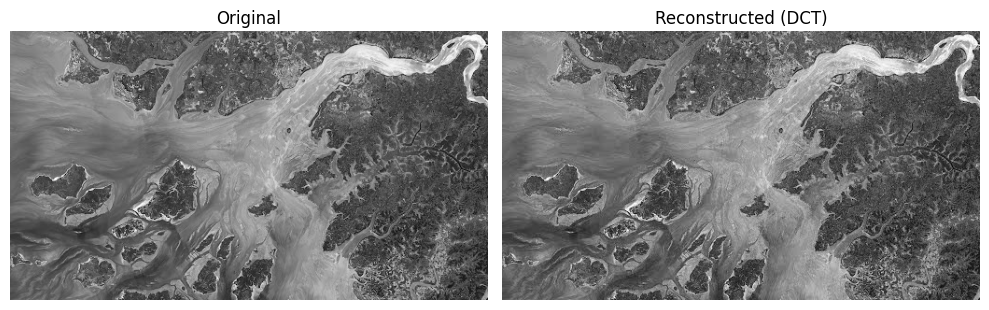

0.7777988910675049


In [13]:
start = time.time()
gray_dct_reconstructed, gray_dct_compression_ratio, gray_dct_psnr_value, gray_dct_ssim_value = dct_image_compression("image_to_compress.jpg", q_factor=20)
gray_dct_time = time.time() - start
print(gray_dct_time)

In [14]:
def dct_image_compression_color(image_path, q_factor=10, block_size=8):
    image_bgr = cv2.imread(image_path)
    color_dct_original_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB).astype(np.float32)

    channels = cv2.split(color_dct_original_rgb)
    color_dct_compressed_channels = []
    color_dct_reconstructed_channels = []
    color_dct_compression_ratios = []
    color_dct_psnrs = []
    color_dct_ssims = []

    for ch in channels:
        blocks, shape = block_process(ch, block_size)

        transformed = np.zeros_like(blocks)
        for i in range(blocks.shape[0]):
            for j in range(blocks.shape[1]):
                transformed[i, j] = dct2(blocks[i, j])

        quantized = quantize(transformed, q_factor)
        dequantized = dequantize(quantized, q_factor)

        reconstructed_blocks = np.zeros_like(blocks)
        for i in range(dequantized.shape[0]):
            for j in range(dequantized.shape[1]):
                reconstructed_blocks[i, j] = idct2(dequantized[i, j])

        reconstructed = unblock_process(reconstructed_blocks, shape)
        reconstructed = np.clip(reconstructed, 0, 255).astype(np.uint8)

        color_dct_compressed_channels.append(quantized)
        color_dct_reconstructed_channels.append(reconstructed)
        color_dct_compression_ratios.append(estimate_compression_ratio(ch, quantized))
        color_dct_psnrs.append(psnr(ch, reconstructed, data_range=255))
        color_dct_ssims.append(ssim(ch, reconstructed, data_range=255))

    color_dct_reconstructed_rgb = cv2.merge(color_dct_reconstructed_channels).astype(np.uint8)
    color_dct_original_rgb = color_dct_original_rgb.astype(np.uint8)

    color_dct_compression_ratio = sum(color_dct_compression_ratios) / 3
    color_dct_psnr_value = sum(color_dct_psnrs) / 3
    color_dct_ssim_value = sum(color_dct_ssims) / 3

    print("\nColor DCT Compression Results:")
    print(f"  Compression Ratio: {color_dct_compression_ratio:.2f}")
    print(f"  PSNR: {color_dct_psnr_value:.2f}")
    print(f"  SSIM: {color_dct_ssim_value:.4f}")

    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.title('Original (RGB)')
    plt.imshow(color_dct_original_rgb)
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.title('Reconstructed (DCT RGB)')
    plt.imshow(color_dct_reconstructed_rgb)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

    return color_dct_reconstructed_rgb, color_dct_compression_ratio, color_dct_psnr_value, color_dct_ssim_value



Color DCT Compression Results:
  Compression Ratio: 3.58
  PSNR: 32.89
  SSIM: 0.9435


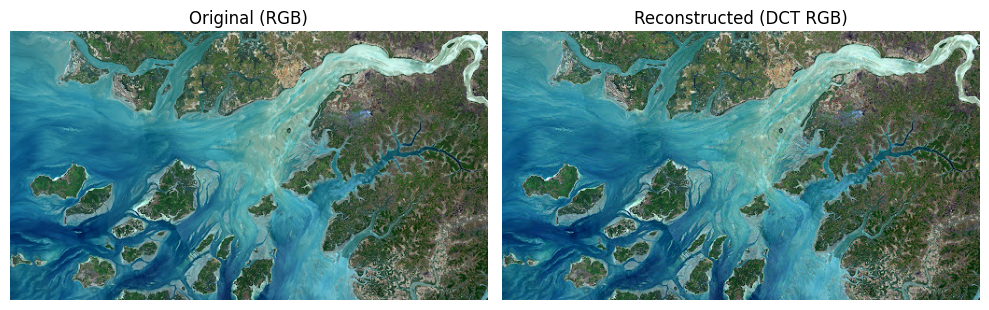

0.9850544929504395


In [15]:
start = time.time()
color_dct_reconstructed_rgb, color_dct_compression_ratio, color_dct_psnr_value, color_dct_ssim_value = dct_image_compression_color("/content/unnamed.jpg", q_factor=20)
color_dct_time = time.time() - start
print(color_dct_time)

# HAAR

In [16]:
def haar_transform_block(block):
    coeffs = pywt.dwt2(block, 'haar')
    cA, (cH, cV, cD) = coeffs
    return np.vstack((np.hstack((cA, cH)), np.hstack((cV, cD))))

def inverse_haar_block(trans_block):
    h = trans_block.shape[0] // 2
    w = trans_block.shape[1] // 2
    cA = trans_block[:h, :w]
    cH = trans_block[:h, w:]
    cV = trans_block[h:, :w]
    cD = trans_block[h:, w:]
    coeffs = (cA, (cH, cV, cD))
    return pywt.idwt2(coeffs, 'haar')

In [17]:
def haar_image_compression(image_path, q_factor=10, block_size=8):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE).astype(np.float32)
    blocks, shape = block_process(image, block_size)

    transformed = np.zeros_like(blocks)
    for i in range(blocks.shape[0]):
        for j in range(blocks.shape[1]):
            transformed[i, j] = haar_transform_block(blocks[i, j])

    quantized = quantize(transformed, q_factor)
    dequantized = dequantize(quantized, q_factor)

    reconstructed_blocks = np.zeros_like(blocks)
    for i in range(dequantized.shape[0]):
        for j in range(dequantized.shape[1]):
            reconstructed_blocks[i, j] = inverse_haar_block(dequantized[i, j])

    gray_haar_reconstructed = unblock_process(reconstructed_blocks, shape)
    gray_haar_reconstructed = np.clip(gray_haar_reconstructed, 0, 255).astype(np.uint8)

    gray_haar_compression_ratio = estimate_compression_ratio(image, quantized)
    gray_haar_psnr_value = psnr(image, gray_haar_reconstructed, data_range=255)
    gray_haar_ssim_value = ssim(image, gray_haar_reconstructed, data_range=255)

    print("\nGrayscale HAAR Compression Results:")
    print(f"  Compression Ratio: {gray_haar_compression_ratio:.2f}")
    print(f"  PSNR: {gray_haar_psnr_value:.2f}")
    print(f"  SSIM: {gray_haar_ssim_value:.4f}")

    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.title('Original')
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.title('Reconstructed')
    plt.imshow(gray_haar_reconstructed, cmap='gray')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

    return gray_haar_reconstructed, gray_haar_compression_ratio, gray_haar_psnr_value, gray_haar_ssim_value


Grayscale HAAR Compression Results:
  Compression Ratio: 2.69
  PSNR: 33.61
  SSIM: 0.9390


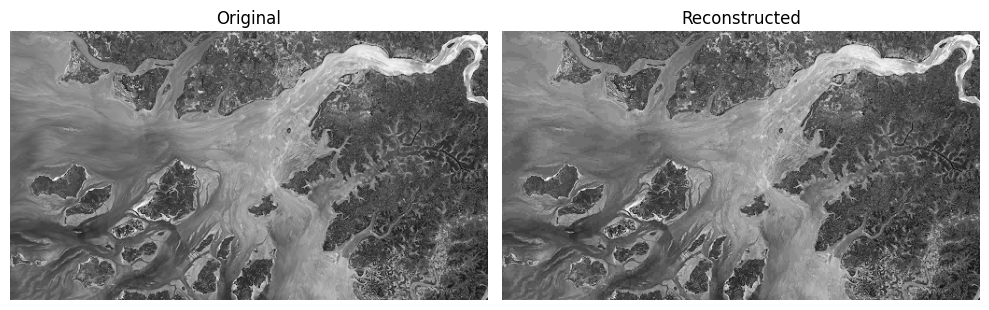

1.3467762470245361


In [18]:
start = time.time()
gray_haar_reconstructed, gray_haar_compression_ratio, gray_haar_psnr_value, gray_haar_ssim_value = haar_image_compression("image_to_compress.jpg", q_factor=20)
gray_haar_time = time.time() - start
print(gray_haar_time)

## HAAR

In [19]:
def haar_image_compression_color(image_path, q_factor=10, block_size=8):
    image_bgr = cv2.imread(image_path)
    color_haar_original_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB).astype(np.float32)

    channels = cv2.split(color_haar_original_rgb)
    color_haar_compressed_channels = []
    color_haar_reconstructed_channels = []
    color_haar_compression_ratios = []
    color_haar_psnrs = []
    color_haar_ssims = []

    for ch in channels:
        blocks, shape = block_process(ch, block_size)

        transformed = np.zeros_like(blocks)
        for i in range(blocks.shape[0]):
            for j in range(blocks.shape[1]):
                transformed[i, j] = haar_transform_block(blocks[i, j])

        quantized = quantize(transformed, q_factor)
        dequantized = dequantize(quantized, q_factor)

        reconstructed_blocks = np.zeros_like(blocks)
        for i in range(dequantized.shape[0]):
            for j in range(dequantized.shape[1]):
                reconstructed_blocks[i, j] = inverse_haar_block(dequantized[i, j])

        reconstructed = unblock_process(reconstructed_blocks, shape)
        reconstructed = np.clip(reconstructed, 0, 255).astype(np.uint8)

        color_haar_compressed_channels.append(quantized)
        color_haar_reconstructed_channels.append(reconstructed)
        color_haar_compression_ratios.append(estimate_compression_ratio(ch, quantized))
        color_haar_psnrs.append(psnr(ch, reconstructed, data_range=255))
        color_haar_ssims.append(ssim(ch, reconstructed, data_range=255))

    color_haar_reconstructed_rgb = cv2.merge(color_haar_reconstructed_channels).astype(np.uint8)
    color_haar_original_rgb = color_haar_original_rgb.astype(np.uint8)

    color_haar_compression_ratio = sum(color_haar_compression_ratios) / 3
    color_haar_psnr_value = sum(color_haar_psnrs) / 3
    color_haar_ssim_value = sum(color_haar_ssims) / 3

    print("\nColor HAAR Compression Results:")
    print(f"  Compression Ratio: {color_haar_compression_ratio:.2f}")
    print(f"  PSNR: {color_haar_psnr_value:.2f}")
    print(f"  SSIM: {color_haar_ssim_value:.4f}")

    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.title('Original (RGB)')
    plt.imshow(color_haar_original_rgb)
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.title('Reconstructed (RGB)')
    plt.imshow(color_haar_reconstructed_rgb)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

    return color_haar_reconstructed_rgb, color_haar_compression_ratio, color_haar_psnr_value, color_haar_ssim_value


Color HAAR Compression Results:
  Compression Ratio: 2.67
  PSNR: 33.59
  SSIM: 0.9418


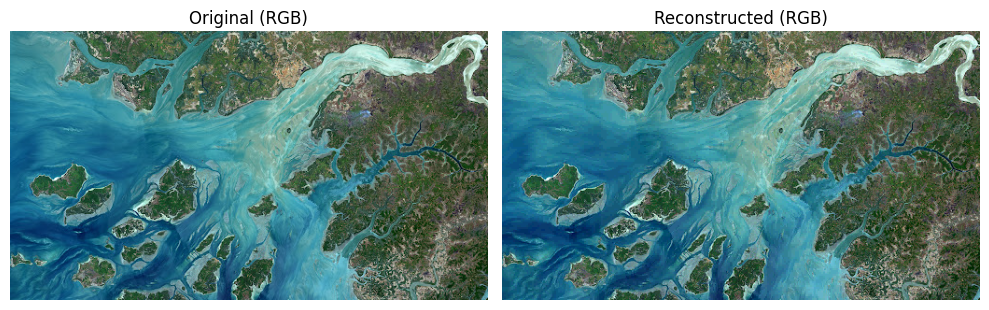

2.447814464569092


In [20]:
start = time.time()
color_haar_reconstructed_rgb, color_haar_compression_ratio, color_haar_psnr_value, color_haar_ssim_value = haar_image_compression_color("/content/unnamed.jpg", q_factor=20)
color_haar_time = time.time() - start
print(color_haar_time)

# Results

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def plot_compression_comparison(metrics_dict):
    df = pd.DataFrame(metrics_dict).T
    df.reset_index(inplace=True)
    df.rename(columns={'index': 'Method'}, inplace=True)

    df['Type'] = df['Method'].apply(lambda x: 'Gray' if x.startswith('gray') else 'Color')
    df['Transform'] = df['Method'].apply(lambda x: x.split('_')[1].upper())

    metrics = ['Compression Ratio', 'PSNR', 'SSIM', 'Time']
    for metric in metrics:
        plt.figure(figsize=(10, 6))
        sns.barplot(data=df, x='Transform', y=metric, hue='Type')
        plt.title(f'{metric} Comparison: Gray vs Color')
        plt.ylabel(metric)
        plt.xlabel('Transform')
        plt.legend(title='Image Type')
        plt.tight_layout()
        plt.show()

    plt.figure(figsize=(12, 6))
    sns.barplot(data=df, x='Method', y='Compression Ratio')
    plt.title('Compression Ratio: All Methods')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(12, 6))
    sns.barplot(data=df, x='Method', y='PSNR')
    plt.title('PSNR: All Methods')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(12, 6))
    sns.barplot(data=df, x='Method', y='SSIM')
    plt.title('SSIM: All Methods')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(12, 6))
    sns.barplot(data=df, x='Method', y='Time')
    plt.title('Time Taken: All Methods')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

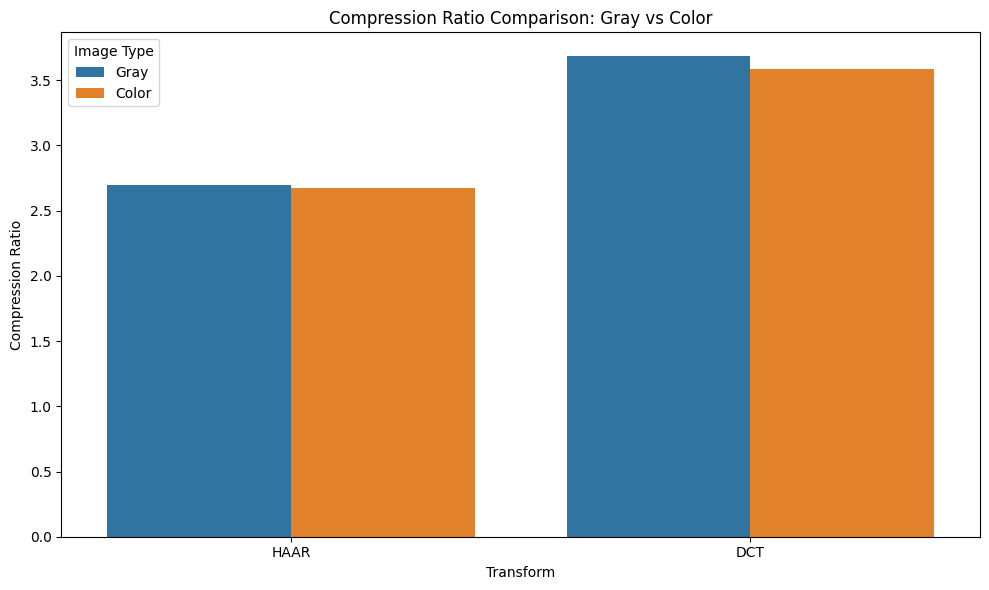

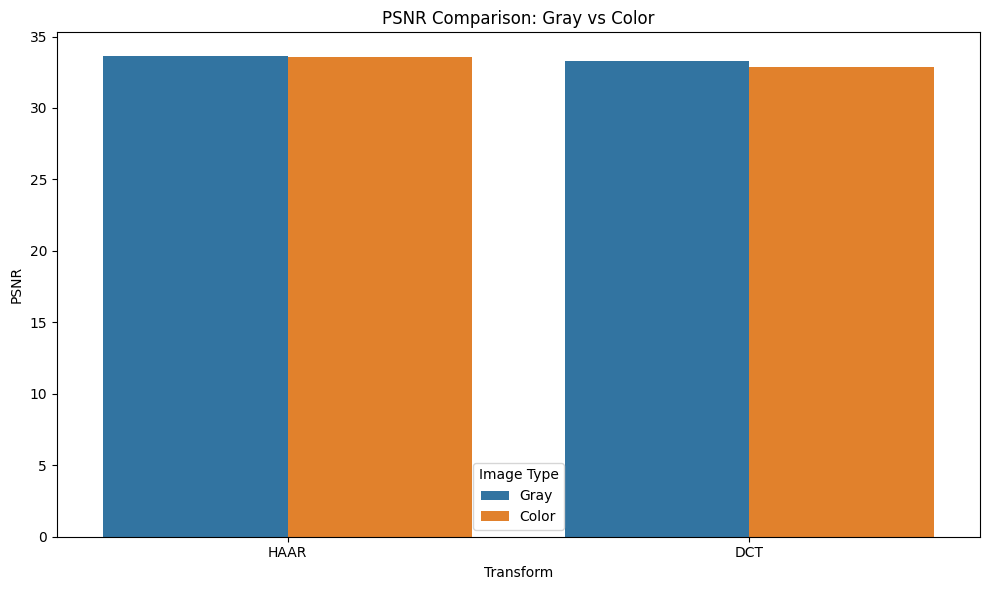

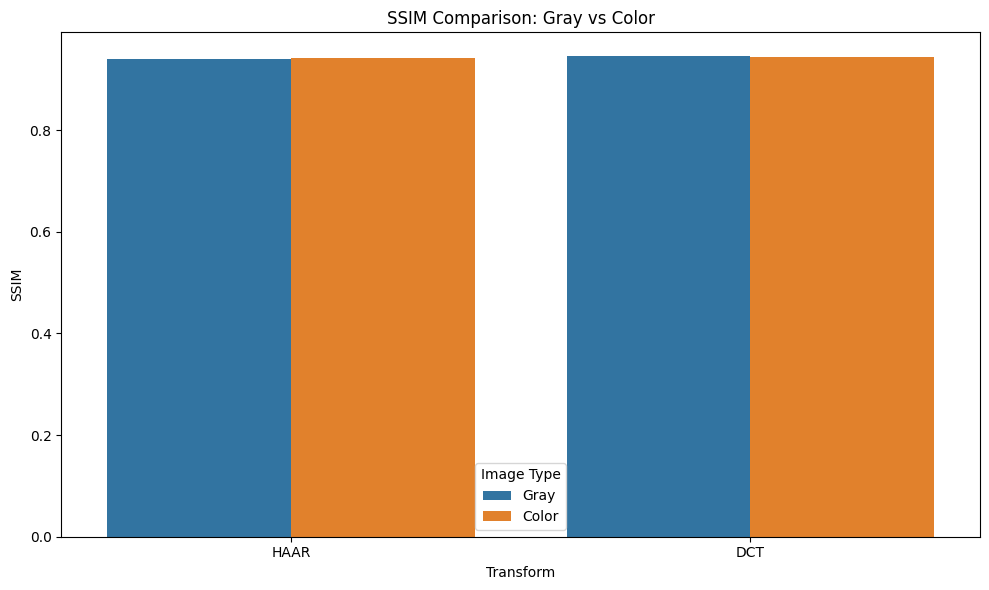

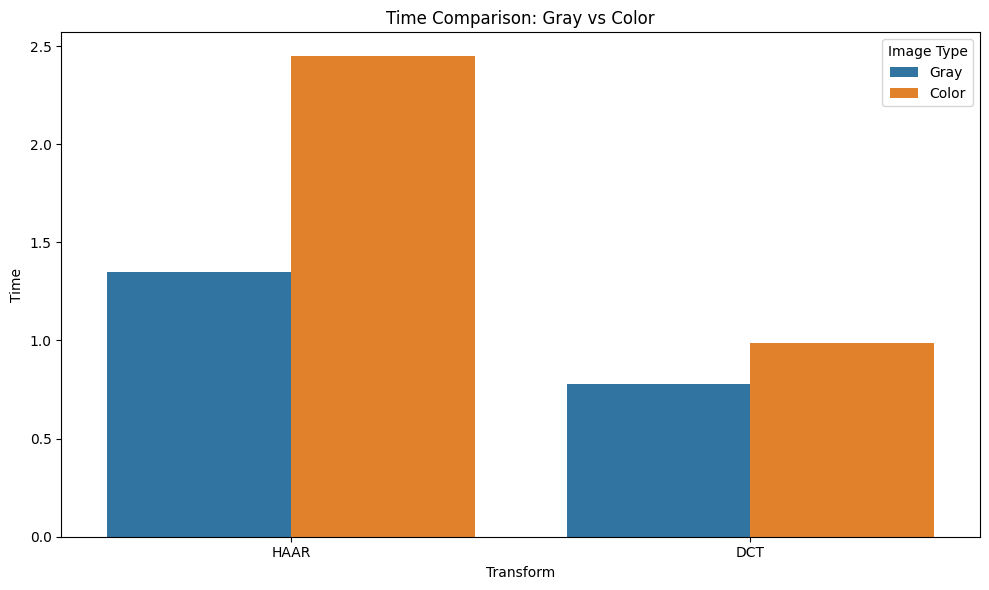

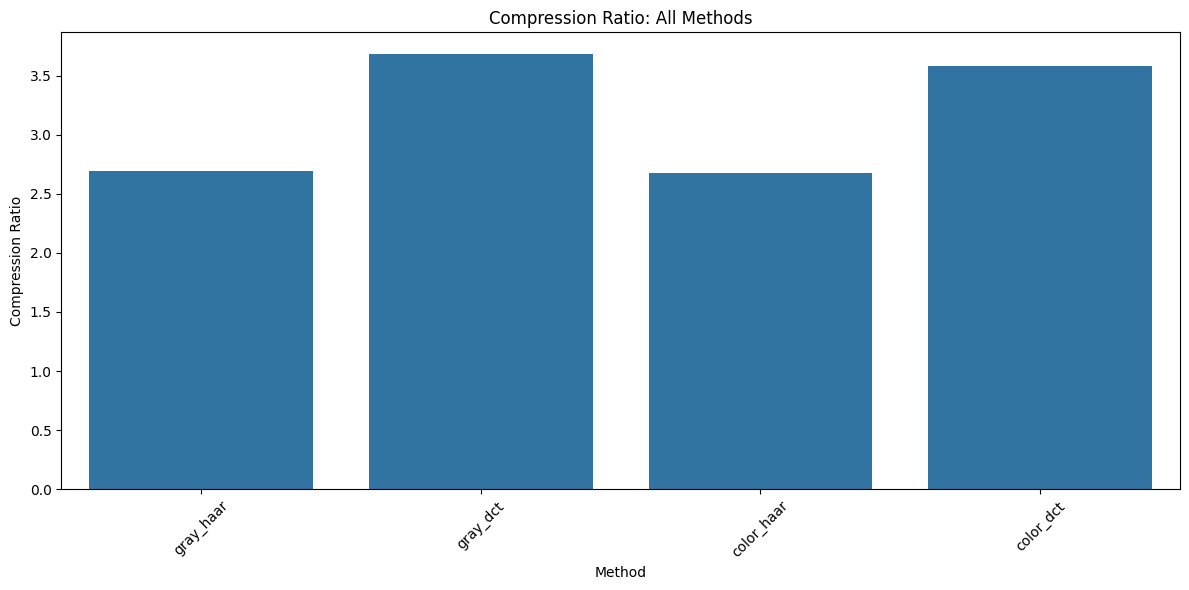

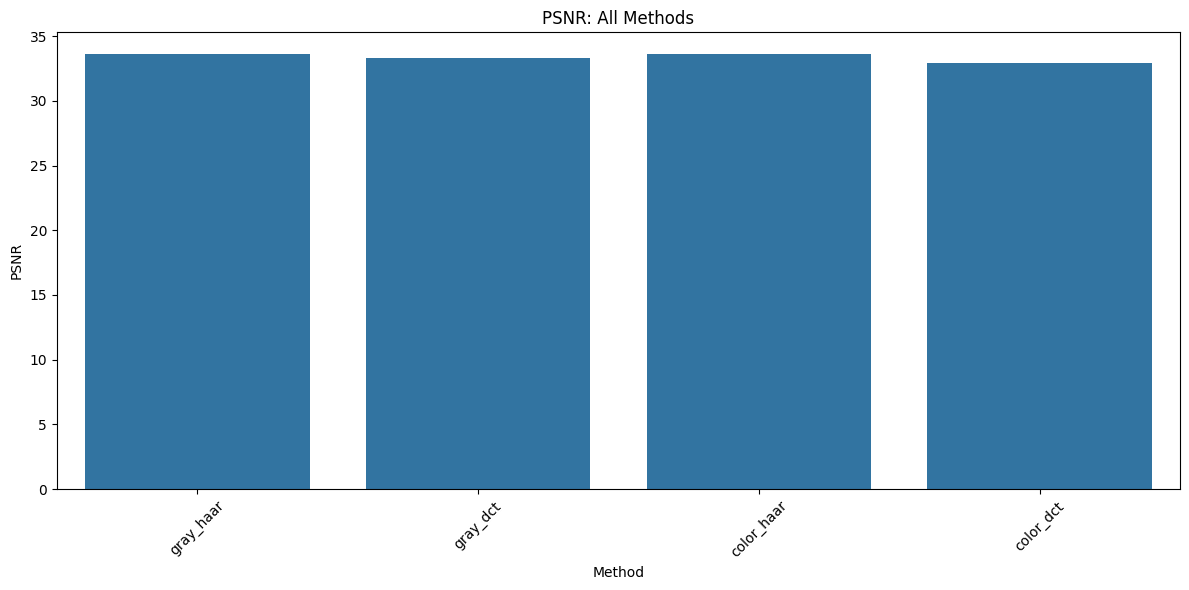

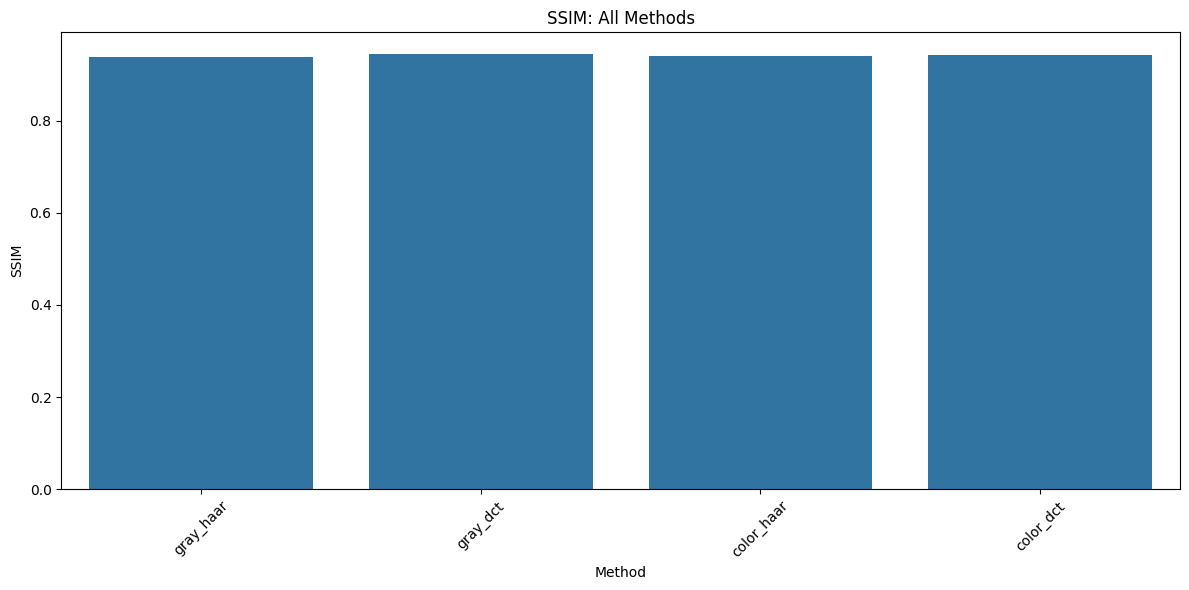

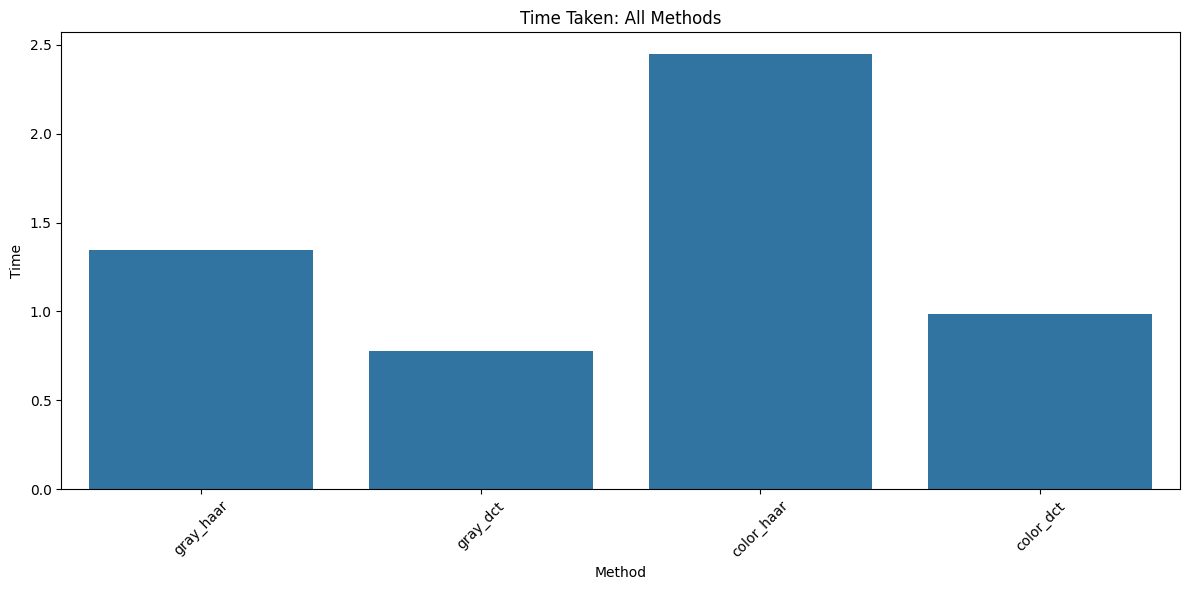

In [22]:
metrics = {
    'gray_haar': {
        'Compression Ratio': gray_haar_compression_ratio,
        'PSNR': gray_haar_psnr_value,
        'SSIM': gray_haar_ssim_value,
        'Time': gray_haar_time
    },
    'gray_dct': {
        'Compression Ratio': gray_dct_compression_ratio,
        'PSNR': gray_dct_psnr_value,
        'SSIM': gray_dct_ssim_value,
        'Time': gray_dct_time
    },
    'color_haar': {
        'Compression Ratio': color_haar_compression_ratio,
        'PSNR': color_haar_psnr_value,
        'SSIM': color_haar_ssim_value,
        'Time': color_haar_time
    },
    'color_dct': {
        'Compression Ratio': color_dct_compression_ratio,
        'PSNR': color_dct_psnr_value,
        'SSIM': color_dct_ssim_value,
        'Time': color_dct_time
    },
}

plot_compression_comparison(metrics)